# GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Download MNIST Dataset

In [ ]:
from torchvision import datasets, transforms

folder = './data'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Resize((32, 32))])

train_set = datasets.MNIST(
    root = folder,
    train = True,
    transform = trans,
    download = True,
)

test_set = datasets.MNIST(
    root = folder,
    train = False,
    transform = trans,
    download = True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4572386.23it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133765.28it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1257643.80it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10303152.39it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def get_data(train_size, test_size):
    train_data = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=train_size,
                 shuffle=True)
    test_data = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=test_size,
                shuffle=True)
    return (train_data, test_data)

# Model 1

In [ ]:
class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()

        self.c1 = nn.Conv2d(1, 6, 5)
        self.c2 = nn.Conv2d(6, 16, 5)
        self.l1 = nn.Linear(16 * 5 * 5, 120)
        self.l2 = nn.Linear(120, 84)
        self.l3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.c1(x)), 2)
        x = F.max_pool2d(F.relu(self.c2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)

        return x

In [ ]:
from os import pread
def train_model(model, loss_func, epoch, data, optimizer):
    average_loss = 0
    sample_size = 0
    correct_predictions = 0
    total_loss = 0
    i=0
    for batch_idx, (x, target) in enumerate(data):
        i+=1
        optimizer.zero_grad()
        x, expected_out = x.to(device), target.to(device)
        #x, expected_out = Variable(x), Variable(target)
        output = model(x)
        loss = loss_func(output, expected_out)
        loss.backward()
        optimizer.step()
        predicted_output = torch.argmax(output, dim=1)
        #predicted_output = np.argmax(output.data.numpy(), axis=1)

        sample_size = sample_size + target.size(0)
        correct_predictions = correct_predictions + (predicted_output == expected_out).sum().item()
        accuracy = 100.0 * correct_predictions / sample_size
        total_loss = total_loss + loss.data

        if (batch_idx+1) % 150 == 0 or (batch_idx+1) == len(data):
            print('Epoch: {}, batch index: {}, accuracy: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, round(accuracy, 2), loss.data))

    total_loss = total_loss/i;
    return total_loss, round(accuracy,2)


train_data, test_data = get_data(64, 1000)
model = Model_1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.CrossEntropyLoss().to(device)
loss_arr = []
accuracy_arr = []

for epoch in range(1, 11):
    model.train()
    loss, accuracy = train_model(model, loss_func, epoch, train_data, optimizer)
    loss_arr.append(loss.cpu().item())
    accuracy_arr.append(accuracy)

Epoch: 1, batch index: 150, accuracy: 63.59, train loss: 0.208008
Epoch: 1, batch index: 300, accuracy: 78.49, train loss: 0.065347
Epoch: 1, batch index: 450, accuracy: 84.09, train loss: 0.090899
Epoch: 1, batch index: 600, accuracy: 87.26, train loss: 0.054596
Epoch: 1, batch index: 750, accuracy: 89.25, train loss: 0.082783
Epoch: 1, batch index: 900, accuracy: 90.61, train loss: 0.072759
Epoch: 1, batch index: 938, accuracy: 90.87, train loss: 0.010059
Epoch: 2, batch index: 150, accuracy: 97.85, train loss: 0.015338
Epoch: 2, batch index: 300, accuracy: 97.93, train loss: 0.041938
Epoch: 2, batch index: 450, accuracy: 97.97, train loss: 0.059378
Epoch: 2, batch index: 600, accuracy: 97.98, train loss: 0.031330
Epoch: 2, batch index: 750, accuracy: 97.99, train loss: 0.041861
Epoch: 2, batch index: 900, accuracy: 98.06, train loss: 0.024943
Epoch: 2, batch index: 938, accuracy: 98.06, train loss: 0.008439
Epoch: 3, batch index: 150, accuracy: 98.67, train loss: 0.027202
Epoch: 3, 

# Model 2

In [ ]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.c1 = nn.Conv2d(1, 32, 5)
        self.c2 = nn.Conv2d(32, 64, 5)
        self.c3 = nn.Conv2d(64, 64, 5)
        self.l1 = nn.Linear(1024, 256)
        self.l2 = nn.Linear(256, 10)
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(F.max_pool2d(self.c2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.c3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.l1(x))
        x = F.dropout(x, training=self.training)
        x = self.l2(x)
        return F.log_softmax(x, dim=1)


train_data, test_data = get_data(64, 1000)
model = Model_2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.CrossEntropyLoss().to(device)
loss_arr_2= []
accuracy_arr_2 = []

for epoch in range(1, 11):
    model.train()
    loss, accuracy = train_model(model, loss_func, epoch, train_data, optimizer)
    loss_arr_2.append(loss.cpu().item())
    accuracy_arr_2.append(accuracy)

Epoch: 1, batch index: 150, accuracy: 63.51, train loss: 0.321486
Epoch: 1, batch index: 300, accuracy: 77.29, train loss: 0.274774
Epoch: 1, batch index: 450, accuracy: 82.84, train loss: 0.140941
Epoch: 1, batch index: 600, accuracy: 85.89, train loss: 0.065375
Epoch: 1, batch index: 750, accuracy: 87.91, train loss: 0.047425
Epoch: 1, batch index: 900, accuracy: 89.28, train loss: 0.033465
Epoch: 1, batch index: 938, accuracy: 89.57, train loss: 0.162696
Epoch: 2, batch index: 150, accuracy: 96.42, train loss: 0.102930
Epoch: 2, batch index: 300, accuracy: 96.71, train loss: 0.194551
Epoch: 2, batch index: 450, accuracy: 96.77, train loss: 0.028893
Epoch: 2, batch index: 600, accuracy: 96.88, train loss: 0.041773
Epoch: 2, batch index: 750, accuracy: 96.93, train loss: 0.199832
Epoch: 2, batch index: 900, accuracy: 96.99, train loss: 0.049077
Epoch: 2, batch index: 938, accuracy: 97.0, train loss: 0.071446
Epoch: 3, batch index: 150, accuracy: 97.58, train loss: 0.062580
Epoch: 3, b

# Accuracy and Loss

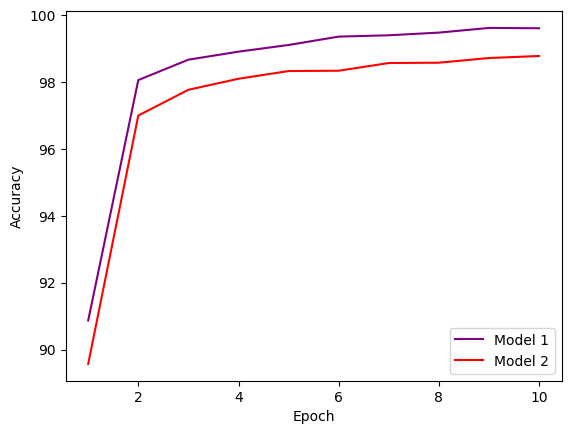

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(np.arange(1,11,1), accuracy_arr, color = "purple")
plt.plot(np.arange(1,11,1), accuracy_arr_2, color = "red")
plt.legend(['Model 1', 'Model 2'])
plt.show()

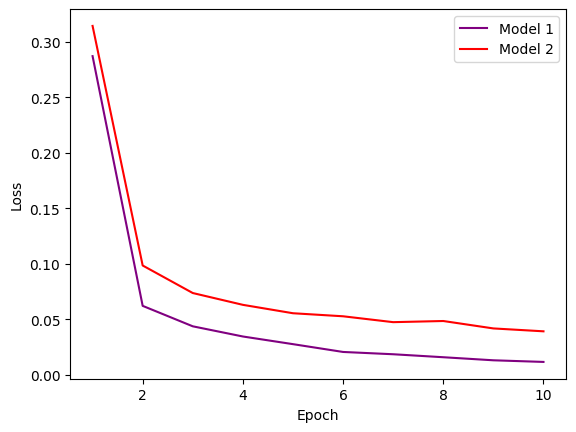

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(np.arange(1, 11, 1), loss_arr, color="purple")
plt.plot(np.arange(1, 11, 1), loss_arr_2, color="red")
plt.legend(['Model 1', 'Model 2'])
plt.show()